In [26]:
# Parameters
temperatures = [0.1, 0.4] # (K)
energy_gaps = [189e-6, 191e-6] # (V)
dynes_parameters = [300e-6, 400e-6] # (V)
transmissions = [0.2] # [0, 1.0]

voltage_parameter = (0,  1.2e-3,  1e-5) # (min, max, step) (V)

import numpy as np
voltage = np.linspace(-1.2e-3, 1.2e-3, 2401)
voltage

array([-0.0012  , -0.001199, -0.001198, ...,  0.001198,  0.001199,
        0.0012  ], shape=(2401,))

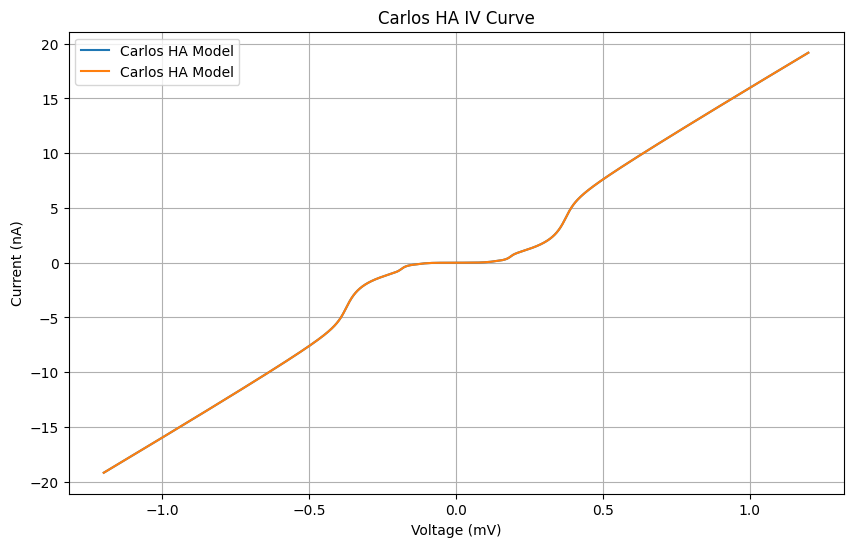

In [ ]:
import os, io
import subprocess
import numpy as np

def get_current_HA(
        voltage_V: np.ndarray,
        temperature_K:float = 0.0,
        energy_gap_V:float = 2e-4,
        dynes_parameter_V:float = 0.0,
        transmission:float=.5,
    ):
    workdir = "/Users/oliver/Documents/p5control-bluefors-evaluation/theory/Carlos HA/"
    iv_exe = os.path.join(workdir, "iv")
    iv_in = os.path.join(workdir, "iv.in")
    tmp_in = os.path.join(workdir, ".tmp_iv.in")

    vstep_mV = np.abs(np.nanmax(voltage_V) - np.nanmin(voltage_V)) / (len(voltage_V) - 1) * 1e3
    vi_mV = np.nanmin(voltage_V) * 1e3 - vstep_mV
    vf_mV = np.nanmax(voltage_V) * 1e3 - vstep_mV

    with open(iv_in, "r") as f:
        lines = f.readlines()

    if dynes_parameter_V <= 0:
        dynes_parameter_V = 0.00001

    lines[0] = f" {temperature_K:.5f} (temp in K)\n"
    lines[1] = f" {energy_gap_V*1e3:.6f} {energy_gap_V*1e3:.6f} (gap1,gap2 in meV)\n"
    lines[2] = f" {transmission:.5f} (transmission)\n"
    lines[3] = f" {dynes_parameter_V*1e3:.6f} {dynes_parameter_V*1e3:.6f} (eta1,eta2 = broadening in meV)\n"
    lines[4] = f" {vi_mV:.8f}  {vf_mV:.8f}  {vstep_mV:.8f} (vi,vf,vstep in mV)\n"

    with open(tmp_in, "w") as f:
        f.writelines(lines)

    proc = subprocess.run(
        [iv_exe],
        stdin=open(tmp_in, "r"),
        capture_output=True,
        text=True,
        cwd=workdir
    )
    
    if proc.returncode != 0:
        print(f"Error running Fortran code:")
        print(proc.stderr)
        return
    
    data = np.genfromtxt(io.StringIO(proc.stdout), dtype='float64')
    voltage = data[:,0] * 1e-3
    current = data[:,1] * 1e-9

    if os.path.isfile(tmp_in):
        os.remove(tmp_in)

    return voltage, current

v, i = get_current_HA(
    voltage_V=voltage, 
    temperature_K=.1, 
    energy_gap_V=189e-6, 
    dynes_parameter_V=0, 
    transmission=0.203,
    )

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(v * 1e3, i * 1e9, label='Carlos HA Model')
plt.plot(voltage * 1e3, i * 1e9, label='Carlos HA Model')
plt.xlabel('Voltage (mV)')
plt.ylabel('Current (nA)')
plt.title('Carlos HA IV Curve')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# run simultaions

"""
Prepares the full parameter grid.
- Loads previous results if available, otherwise initializes new arrays.
- Defines helper functions to expand axes and arrays if new parameter values are introduced.
- Ensures the data structure is always up-to-date with the current parameter grid.
- Defines the function to run the Fortran simulation for a given parameter set.
- Finds which parameter combinations are missing (not yet simulated).
- Runs only the missing simulations in parallel, updating the results array.
- Saves the updated results to the pickle file.
"""

import subprocess
import numpy as np
import os
import itertools
import pickle
import shutil
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.constants import h, e # Planck's constant and elementary charge
G_0 = e**2 / h  # conductance quantum in S

workdir = "/Users/oliver/Documents/p5control-bluefors-evaluation/theory/Carlos HA/"
iv_exe = os.path.join(workdir, "iv")
iv_in = os.path.join(workdir, "iv.in")
tmp_input_dir = os.path.join(workdir, "tmp_inputs")
data_dir = os.path.join(workdir, "data")

# --- pickle filename ---
vp_str = f"({voltage_parameter[0]:.3e}, {voltage_parameter[1]:.3e}, {voltage_parameter[2]:.3e})"
pickle_path = os.path.join(workdir, data_dir, f"iv_{vp_str}.pickle")

# Prepare parameter grid
os.makedirs(data_dir, exist_ok=True)
os.makedirs(tmp_input_dir, exist_ok=True)
param_grid = list(itertools.product(temperatures, energy_gaps, transmissions, dynes_parameters))

# Try to load previous results
if os.path.exists(pickle_path):
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)
    current = data["current_A"]
    all_temperatures = data["temperatures_K"]
    all_gaps = data["energy_gaps_V"]
    all_trans = data["transmissions"]
    all_dynes = data["dynes_parameter_V"]
    voltages = data["voltages_V"]
else:
    all_temperatures = np.array(sorted(set(temperatures)))
    all_gaps = np.array(sorted(set(energy_gaps)))
    all_trans = np.array(sorted(set(transmissions)))
    all_dynes = np.array(sorted(set(dynes_parameters)))
    voltages = np.arange(
        voltage_parameter[0], 
        voltage_parameter[1] + voltage_parameter[2], 
        voltage_parameter[2])
    current = np.full(
        (len(all_temperatures), len(all_gaps), len(all_trans), len(all_dynes), len(voltages)),
        np.nan
    )

def expand_axis(old_axis, new_axis):
    """Return sorted union of old and new axis."""
    return np.array(sorted(set(old_axis) | set(new_axis)))

def expand_current_array(current, old_axes, new_axes):
    """Expand the current array to fit new axes, preserving old data."""
    shape = [len(ax) for ax in new_axes]
    shape.append(current.shape[-1])  # voltages axis
    new_current = np.full(shape, np.nan)
    # Map old indices to new indices
    for idx_old, t in enumerate(old_axes[0]):
        i_t = np.where(new_axes[0] == t)[0][0]
        for idx_g, g in enumerate(old_axes[1]):
            i_g = np.where(new_axes[1] == g)[0][0]
            for idx_tr, tr in enumerate(old_axes[2]):
                i_tr = np.where(new_axes[2] == tr)[0][0]
                for idx_d, d in enumerate(old_axes[3]):
                    i_d = np.where(new_axes[3] == d)[0][0]
                    new_current[i_t, i_g, i_tr, i_d, :] = current[idx_old, idx_g, idx_tr, idx_d, :]
    return new_current


# After loading pickle:
if os.path.exists(pickle_path):
    with open(pickle_path, "rb") as f:
        data = pickle.load(f)
    current = data["current_A"]
    all_temperatures = data["temperatures_K"]
    all_gaps = data["energy_gaps_V"]
    all_trans = data["transmissions"]
    all_dynes = data["dynes_parameter_V"]
    voltages = data["voltages_V"]

    # --- EXPAND AXES IF NEEDED ---
    new_temperatures = expand_axis(all_temperatures, temperatures)
    new_gaps = expand_axis(all_gaps, energy_gaps)
    new_trans = expand_axis(all_trans, transmissions)
    new_dynes = expand_axis(all_dynes, dynes_parameters)
    if (
        not np.array_equal(new_temperatures, all_temperatures) or
        not np.array_equal(new_gaps, all_gaps) or
        not np.array_equal(new_trans, all_trans) or
        not np.array_equal(new_dynes, all_dynes)
    ):
        current = expand_current_array(
            current,
            [all_temperatures, all_gaps, all_trans, all_dynes],
            [new_temperatures, new_gaps, new_trans, new_dynes]
        )
        all_temperatures = new_temperatures
        all_gaps = new_gaps
        all_trans = new_trans
        all_dynes = new_dynes

def run_iv(temp, gap, trans, dyne):
    tmp_in = os.path.join(
        tmp_input_dir,
        f"_V=({voltage_parameter[0]:.2e}, {voltage_parameter[1]:.2e}, {voltage_parameter[2]:.2e})_Delta={gap}_Gamma={dyne}_T={temp}_tau={trans}.in",
    )
    with open(iv_in, "r") as f:
        lines = f.readlines()
    lines[0] = f"{temp:.5f} (temp in K)\n"
    lines[1] = f"{gap*1e3:.3f} {gap*1e3:.3f} (gap1,gap2 in meV)\n"
    lines[2] = f"{trans:.2f} (transmission)\n"
    lines[3] = f"{dyne*1e3:.3f} {dyne*1e3:.3f} (eta1,eta2 = broadening in meV)\n"
    lines[4] = f"{(voltage_parameter[0]-voltage_parameter[2])*1e3:.3f} {(voltage_parameter[1]+voltage_parameter[2])*1e3:.3f} {voltage_parameter[2]*1e3:.5f} (vi,vf,vstep in mV)\n"
    with open(tmp_in, "w") as f:
        f.writelines(lines)
    proc = subprocess.run(
        [iv_exe],
        stdin=open(tmp_in, "r"),
        capture_output=True,
        text=True,
        cwd=workdir
    )
    if proc.returncode != 0:
        print(f"Error running Fortran code for {temp, gap, trans, dyne}:")
        print(proc.stderr)
        return (temp, gap, trans, dyne), None
    data = []
    for line in proc.stdout.splitlines():
        try:
            v, i = map(float, line.split())
            data.append((v*1e-3, i*1e-9))  # mV->V, nA->A
        except Exception:
            continue
    data = np.array(data)
    return (temp, gap, trans, dyne), data

def get_indices(temp, gap, trans, dyne):
    def find(arr, val, name):
        idx = np.where(arr == val)[0]
        if len(idx) == 0:
            raise ValueError(f"{val} not found in {name}: {arr}")
        return idx[0]
    return (
        find(all_temperatures, temp, "all_temperatures"),
        find(all_gaps, gap, "all_gaps"),
        find(all_trans, trans, "all_trans"),
        find(all_dynes, dyne, "all_dynes"),
    )

# Find missing
missing = []
for t, g, tr, d in param_grid:
    try:
        i_t, i_g, i_tr, i_d = get_indices(t, g, tr, d)
        if np.isnan(current[i_t, i_g, i_tr, i_d, 0]):
            missing.append((t, g, tr, d))
    except ValueError as e:
        print(f"Parameter not found in axes: {e}")
        # Optionally, add logic to expand axes and current array if needed

# Run missing
if missing:
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(run_iv, *params) for params in missing]
        for future in tqdm(as_completed(futures), total=len(futures), desc="IV simulations", unit="sim"):
            key, data_arr = future.result()
            if data_arr is not None and data_arr.size:
                i_t, i_g, i_tr, i_d = get_indices(*key)
                print(data_arr[:,0], voltages)
                current[i_t, i_g, i_tr, i_d, :] = data_arr[:len(voltages),1]
    # Save updated dictionary
    data = {
        "temperatures_K": all_temperatures,
        "energy_gaps_V": all_gaps,
        "transmissions": all_trans,
        "dynes_parameter_V": all_dynes,
        "voltages_V": voltages,
        "voltage_parameter_V": np.array(voltage_parameter),
        "current_A": current,
        "differential_conductance_G0": np.gradient(current, voltages, axis=-1) / G_0,
    }
    with open(pickle_path, "wb") as f:
        pickle.dump(data, f)
    print("Saved updated results to", pickle_path)
else:
    print("No missing simulations. All results present.")

if os.path.exists(tmp_input_dir):
    for filename in os.listdir(tmp_input_dir):
        file_path = os.path.join(tmp_input_dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
    shutil.rmtree(tmp_input_dir)
    print(f"Deleted temp files.")
data

IV simulations: 100%|██████████| 4/4 [00:11<00:00,  2.76s/sim]

[0.000e+00 1.000e-06 2.000e-06 ... 1.200e-03 1.201e-03 1.202e-03] [0.000e+00 1.000e-06 2.000e-06 ... 1.198e-03 1.199e-03 1.200e-03]
[0.000e+00 1.000e-06 2.000e-06 ... 1.200e-03 1.201e-03 1.202e-03] [0.000e+00 1.000e-06 2.000e-06 ... 1.198e-03 1.199e-03 1.200e-03]
[0.000e+00 1.000e-06 2.000e-06 ... 1.200e-03 1.201e-03 1.202e-03] [0.000e+00 1.000e-06 2.000e-06 ... 1.198e-03 1.199e-03 1.200e-03]
[0.000e+00 1.000e-06 2.000e-06 ... 1.200e-03 1.201e-03 1.202e-03] [0.000e+00 1.000e-06 2.000e-06 ... 1.198e-03 1.199e-03 1.200e-03]
Saved updated results to /Users/oliver/Documents/p5control-bluefors-evaluation/theory/Carlos HA/data/iv_(0.000e+00, 1.200e-03, 1.000e-06).pickle
Deleted temp files.


{'temperatures_K': array([0.1, 0.2, 0.4]),
 'energy_gaps_V': array([0.000189, 0.000191]),
 'transmissions': array([0.1, 0.2, 0.8]),
 'dynes_parameter_V': array([0.0003, 0.0004]),
 'voltages_V': array([0.000e+00, 1.000e-06, 2.000e-06, ..., 1.198e-03, 1.199e-03,
        1.200e-03], shape=(1201,)),
 'voltage_parameter_V': array([0.0e+00, 1.2e-03, 1.0e-06]),
 'current_A': array([[[[[0.00000000e+00, 5.80058591e-12, 1.16012515e-11, ...,
            9.13604584e-09, 9.14395655e-09, 9.15186703e-09],
           [0.00000000e+00, 6.51541976e-12, 1.30308746e-11, ...,
            9.13150645e-09, 9.13939288e-09, 9.14727915e-09]],
 
          [[0.00000000e+00, 1.21278904e-11, 2.42559488e-11, ...,
            1.84263480e-08, 1.84421512e-08, 1.84579540e-08],
           [0.00000000e+00, 1.34020283e-11, 2.68041257e-11, ...,
            1.83863032e-08, 1.84020641e-08, 1.84178248e-08]],
 
          [[0.00000000e+00, 6.53493374e-11, 1.30699060e-10, ...,
            7.75593902e-08, 7.76222019e-08, 7.76850123e

In [23]:
# Cleanup cell: Delete all iv.pickle file

# if os.path.exists(data_dir):
#     for filename in os.listdir(data_dir):
#         file_path = os.path.join(data_dir, filename)
#         if os.path.isfile(file_path):
#             os.remove(file_path)
#     shutil.rmtree(data_dir)
#     print(f"Deleted pickle files.")